# Python / Tensorflow implementation of the kernel measure compression algorithm

In this notebook you can find a Python / Tensorflow implementation of the kernel measure compression algorithm in the paper
"Algorithms that get old : the case of generative deep neural networks" published in the LOD conference proceedings and arXiv:2202.03008 [stat.ML], direct link : https://arxiv.org/abs/2202.03008



## Library imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bernoulli 
from scipy.special import softmax as scipy_softmax
import pandas as pd
from tqdm import tqdm

In [2]:
K=3*16#number of Dirac masses in the compressed distribution
N=2#ambient dimension
J=1000#how many samples are included: more the better, otherwise there are oscillations in the SGD/Adam convergence
optimize_weights=True
optimize_weights=False

quant=tf.Variable(np.random.rand(N,K),dtype=tf.float32)#this will be the set of quantization variables
if(optimize_weights):
  alphas=tf.Variable(np.ones(K)/K,dtype=tf.float32)#this will be the set of quantization weights

def loss(quant,batch):
  #sum_dist_normal=tf.math.sqrt ...
  return None 


## Define empirical sampling

Here is the place where one defines the target measure to be compressed. It is usually given by a function that returns i.i.d samples from this measure.

In [3]:
def empirical_sampling_multiD_gaussian(tmpN=N,tmpJ=J):
    ''' sample from the empirical, target distribution: size as Y
    Here the target is a N-dimensional Gaussian distribution
    '''    
    return np.random.randn(tmpN,tmpJ)

my_bernoulli=bernoulli(0.3)

def empirical_sampling_mixture_two_gaussians(tmpN=N,tmpJ=J):
    ''' sample from the empirical, target distribution: size as Y
    this returns samples under a mixture of two gaussians, one centered in (-5,5) the other in (5,5)
    '''    
    return np.random.randn(tmpN,tmpJ)-5+10*my_bernoulli.rvs(tmpJ)


def empirical_sampling_mixture_2D_16_gaussians(tmpN=N,tmpJ=J):
    ''' sample from the empirical, target distribution: size as Y
    this returns samples under a mixture of 16 gaussians, centered on a regular grid (i,j)
    '''    
    assert(tmpN==2), "invalid dimension in 2D 16-Gaussian mixture sampling"
    return np.random.randn(tmpN,tmpJ)+ 5*np.array([np.random.choice(4,tmpJ),np.random.choice(4,tmpJ)])

# 1 N-dim Gaussian
#empirical_sampling=empirical_sampling_multiD_gaussian
#centers=np.array([[0,0]])

#empirical_sampling=empirical_sampling_mixture_two_gaussians 

#16 2D Gaussian on a grid
empirical_sampling=empirical_sampling_mixture_2D_16_gaussians 
centers=np.reshape(5*np.array([[(i,j) for j in [0,1,2,3]] for i in [0,1,2,3]]),(-1,2))



# Empirical Radon Sobolev distance

In [4]:

def empirical_radon_sobolev_distance_sq(X,Y,local_alphas=None,betas=None):
    '''
    

    Parameters
    ----------
    X : 2D NxK matrix
        input data sample, each column a vector of dimension N, notation X_k
    Y : same as X for the second distribution
    alphas : 1D array of weights for X
    betas : same as alphas for Y 

    Note: X,alphas are Tensor/Variable while Y/betas are numpy array

    Returns
    -------
    Radon-Sobolev distance
    
    '''
    N,K=X.shape
    Ny,J=Y.shape
    Ytensor = tf.convert_to_tensor(Y, dtype=tf.float32)

    if local_alphas is None:
      alphas = tf.convert_to_tensor(np.ones(K)/K,dtype=tf.float32)
    else:
      alphas=tf.nn.softmax(local_alphas)
    if betas is None:
        betas = np.ones(J)/J
    betastensor = tf.convert_to_tensor(betas, dtype=tf.float32)
    
    assert (tf.rank(X).numpy()==2) & (Y.ndim==2) & (tf.rank(alphas).numpy()==1) & (betas.ndim==1),"invalid input dimensions"
    Ka,=alphas.shape
    Jb,=betas.shape
    assert (N==Ny)& (K==Ka)&(J==Jb), 'invalid input dimensions'

    points=tf.concat([X,Ytensor],axis=1)
    gammas=tf.concat([alphas,-betastensor],axis=0)
    distZZ = tf.math.sqrt(1.0e-10+tf.math.reduce_sum(tf.square(tf.expand_dims(points,2)-tf.expand_dims(points,1)),axis=0))-1.0e-5

    return tf.squeeze(-0.5*tf.expand_dims(gammas,0)@distZZ@tf.expand_dims(gammas,1))


print(empirical_radon_sobolev_distance_sq(tf.ones([N,K]),tf.zeros([N,J])))
print(empirical_radon_sobolev_distance_sq(tf.zeros([1,1]),empirical_sampling_multiD_gaussian(tmpN=1,tmpJ=1000)))
print(empirical_radon_sobolev_distance_sq( tf.convert_to_tensor( np.array([[-1,1],[-1,1]]), dtype=tf.float32),
                                          np.array([[-1,-1,1,1],[-1,1,-1,1]])))

tf.Tensor(1.4142265, shape=(), dtype=float32)
tf.Tensor(0.234323, shape=(), dtype=float32)
tf.Tensor(0.14644536, shape=(), dtype=float32)


## Main optimization loop

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.30it/s]


quant= [[ 5.3093157   0.682921   15.456997    0.23340558 14.771892   15.4533615
  -0.71028054  9.490565   13.38673     3.7918675   3.9742148   0.84803516
  -0.8538658  14.27294     4.6380143  10.984693   -0.67901206 15.369488
   4.9526696   9.751066    9.245594    2.6414666   6.341574    3.7910347
  15.71351    -0.36242786 14.295924   -0.5137076  10.982422    3.9773533
   9.464758   10.992154    9.091683    9.646452   -0.3020533  15.492368
   5.0246243   5.7287245   9.501602    5.902519    0.67150533  9.689404
   5.5215173  16.101797   11.209333   13.961465   15.657073   -0.87177265]
 [14.189471   15.359586    4.247375    9.543268    0.8460349   8.917108
  -1.1015898  11.1290865   4.482312   15.296689    8.661717   -0.26037204
  10.289277   10.151545    5.6709347   0.02230444  6.3772964  14.064197
  10.397947    3.904165    0.34173298 11.235192    9.750341    4.022881
  10.851737    1.0900495  -0.8851819   4.222088    5.718074    0.22316016
  16.017618   14.995735    5.5960097   9.2941

<BarContainer object of 48 artists>

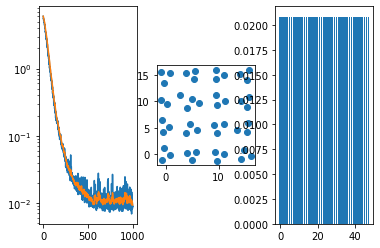

In [5]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1,beta_1=0.9, beta_2=0.999)# TODO: use lr_schedule for step decay schedule !

if (optimize_weights):   
  loss_quant = lambda: empirical_radon_sobolev_distance_sq(quant,empirical_sampling(),alphas)
else:
  loss_quant = lambda: empirical_radon_sobolev_distance_sq(quant,empirical_sampling())


nr_iter=1000
loss_val=[]
opt_val=[]
alphas_raw_val=[]
alphas_true_val=[]

for sc in tqdm(range(nr_iter)):
  #step_count = opt.minimize(loss, [var1]).numpy()
  if (optimize_weights):   
    step_count = opt.minimize(loss_quant, [quant,alphas]).numpy()
  else:
    step_count = opt.minimize(loss_quant, [quant]).numpy()


  opt_val.append(quant.numpy())
  loss_val.append(loss_quant())

if (optimize_weights):   
  alphas_raw_val.append(alphas.numpy())
  alphas_true_val.append(scipy_softmax(alphas.numpy()))
else:
  alphas_raw_val.append(np.ones(K)/K)
  alphas_true_val.append(np.ones(K)/K)

print('quant=',quant.numpy(),' step_count=',step_count,' alphas=',alphas_true_val[-1])
plt.figure(1)
plt.subplot(1,3,1)
plt.semilogy(loss_val)
df = pd.Series(loss_val)
plt.semilogy(np.array(df.ewm(span=10).mean()))
ax2=plt.subplot(1,3,2)
plt.scatter(np.array(opt_val)[-1,0,:],np.array(opt_val)[-1,1,:])
ax2.set_aspect(1.)
plt.subplot(1,3,3)
plt.bar(list(np.arange(alphas_raw_val[-1].shape[0])),alphas_true_val[-1])

## Further plots and outputs

In [6]:
print("final loss value",loss_val[-1:])
print("final compression points",opt_val[-1])

final loss value [<tf.Tensor: shape=(), dtype=float32, numpy=0.008856691>]
final compression points [[ 5.3093157   0.682921   15.456997    0.23340558 14.771892   15.4533615
  -0.71028054  9.490565   13.38673     3.7918675   3.9742148   0.84803516
  -0.8538658  14.27294     4.6380143  10.984693   -0.67901206 15.369488
   4.9526696   9.751066    9.245594    2.6414666   6.341574    3.7910347
  15.71351    -0.36242786 14.295924   -0.5137076  10.982422    3.9773533
   9.464758   10.992154    9.091683    9.646452   -0.3020533  15.492368
   5.0246243   5.7287245   9.501602    5.902519    0.67150533  9.689404
   5.5215173  16.101797   11.209333   13.961465   15.657073   -0.87177265]
 [14.189471   15.359586    4.247375    9.543268    0.8460349   8.917108
  -1.1015898  11.1290865   4.482312   15.296689    8.661717   -0.26037204
  10.289277   10.151545    5.6709347   0.02230444  6.3772964  14.064197
  10.397947    3.904165    0.34173298 11.235192    9.750341    4.022881
  10.851737    1.0900495  

<BarContainer object of 48 artists>

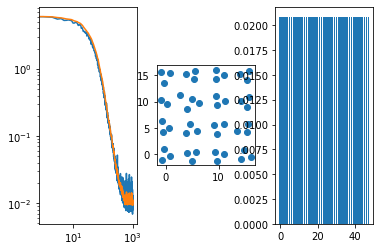

In [7]:
plt.figure(1)
plt.subplot(1,3,1)
plt.loglog(loss_val)
df = pd.Series(loss_val)
plt.loglog(np.array(df.ewm(span=10).mean()))
ax2=plt.subplot(1,3,2)
plt.scatter(np.array(opt_val)[-1,0,:],np.array(opt_val)[-1,1,:])
ax2.set_aspect(1.)
plt.subplot(1,3,3)
plt.bar(list(np.arange(alphas_raw_val[-1].shape[0])),alphas_true_val[-1])


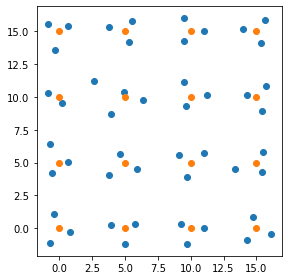

In [8]:
#only plot the middle one
plt.figure(2)
ax2=plt.subplot(1,1,1)
plt.scatter(np.array(opt_val)[-1,0,:],np.array(opt_val)[-1,1,:])
plt.scatter(centers[:,0],centers[:,1])
ax2.set_aspect(1.)
plt.tight_layout()
plt.savefig('16_Gaussians_K'+str(K)+'.pdf')